# GeoPandas Gridding Example

*Rob Knapen, Wageningen Environmental Research*
<br>

A notebook for trying out GeoPandas for gridding species observations.

### Import Python Packages

In [18]:
import os

import matplotlib.pyplot as plt

os.environ['USE_PYGEOS'] = '0'

import pandas as pd
import numpy as np
import geopandas as gp

import shapely

from geocube.api.core import make_geocube

### Load sample species observation data
As an example a dataset from the Dutch 'Nationale Databank Flora en Fauna' (ndff.nl). While we are hoping for this to be available as open data (soon), it is not yet. However, we have permission to use it for the FAIRiCUBE EU project.

In [19]:
# the NDFF datafile to process
obs_filename = "../../../local/data/ndff/broedvogels_2016.csv"

# the columns to drop right away
always_drop_cols_from_source = None

# area of interest
aoi_epsg = 'EPSG:32631' # WGS 84 / UTM zone 31N
aoi_xmin =  674900.0
aoi_xmax =  729800.0
aoi_ymin = 5832230.0
aoi_ymax = 5853960.0

### Use a Pandas DataFrame for some pre-processing
Do some initial cleaning of the data first. Also fix the geometry data so it fits GeoPandas expectations.

In [20]:
# load the data into a regular pandas dataframe
obs_df = pd.read_csv(obs_filename, header='infer', sep=';', on_bad_lines='warn')

# remove not needed columns
if always_drop_cols_from_source:
    obs_df.drop(columns=always_drop_cols_from_source, inplace=True)

# remove the crs prefix from the wkt data
obs_df['wkt_excl_crs'] = obs_df['wkt'].map(lambda x: x.split(';')[1], na_action='ignore')
obs_df.drop(columns=['wkt'], inplace=True)
obs_df.rename(columns={'wkt_excl_crs': 'wkt'}, inplace=True)

obs_df.head(5)

,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,wkt
0,Krakeend,Anas strepera,2016,territorium,1,71,"POLYGON((247282 584478,247280.535533906 584474..."
1,Zwartkop,Sylvia atricapilla,2016,territorium,1,283,"POLYGON((65405.294923655 436165.134083641,6540..."
2,Zanglijster,Turdus philomelos,2016,territorium,1,283,"POLYGON((188642.918478918 344195.927912087,188..."
3,Zanglijster,Turdus philomelos,2016,territorium,1,283,"POLYGON((169116.484375 446596.0625,169113.5554..."
4,Spreeuw,Sturnus vulgaris,2016,nest,1,283,"POLYGON((127692 427328,127689.071067812 427320..."


### Lift the data into a GeoPandas GeoDataFrame
Create a GeoPandas GeoDataFrame from the regular (non spatial aware) DataFrame. After that use GeoPandas functionality to transform the data from the Dutch coordinate reference system to the preferred CRS for the area of interest.

In [21]:
# note that we used the pandas dataframe
obs_gs = gp.GeoSeries.from_wkt(obs_df['wkt'])
obs_gdf = gp.GeoDataFrame(obs_df, geometry=obs_gs, crs='EPSG:28992')

# transform the dataset to the CRS of the area of interest
obs_gdf.to_crs(crs=aoi_epsg, inplace=True)
obs_gdf.drop(columns=['wkt'], inplace=True)

obs_gdf.head(5)

,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,geometry
0,Krakeend,Anas strepera,2016,territorium,1,71,"POLYGON ((751518.337 5905480.782, 751516.991 5..."
1,Zwartkop,Sylvia atricapilla,2016,territorium,1,283,"POLYGON ((574652.165 5751224.946, 574649.470 5..."
2,Zanglijster,Turdus philomelos,2016,territorium,1,283,"POLYGON ((700809.959 5663334.067, 700807.260 5..."
3,Zanglijster,Turdus philomelos,2016,territorium,1,283,"POLYGON ((677952.618 5765052.467, 677949.923 5..."
4,Spreeuw,Sturnus vulgaris,2016,nest,1,283,"POLYGON ((637182.769 5744436.329, 637180.073 5..."


### Data selection

In [22]:
# only execute this cell when you want to change the aoi to the full dataset!
aoi_xmin = obs_gdf.total_bounds[0]
aoi_ymin = obs_gdf.total_bounds[1]
aoi_xmax = obs_gdf.total_bounds[2]
aoi_ymax = obs_gdf.total_bounds[3]

In [23]:
# spatially select observations within an area of interest
aoi_obs_gdf = obs_gdf.cx[aoi_xmin:aoi_xmax, aoi_ymin:aoi_ymax]
aoi_obs_gdf.head(5)

,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,geometry
0,Krakeend,Anas strepera,2016,territorium,1,71,"POLYGON ((751518.337 5905480.782, 751516.991 5..."
1,Zwartkop,Sylvia atricapilla,2016,territorium,1,283,"POLYGON ((574652.165 5751224.946, 574649.470 5..."
2,Zanglijster,Turdus philomelos,2016,territorium,1,283,"POLYGON ((700809.959 5663334.067, 700807.260 5..."
3,Zanglijster,Turdus philomelos,2016,territorium,1,283,"POLYGON ((677952.618 5765052.467, 677949.923 5..."
4,Spreeuw,Sturnus vulgaris,2016,nest,1,283,"POLYGON ((637182.769 5744436.329, 637180.073 5..."


<Axes: >

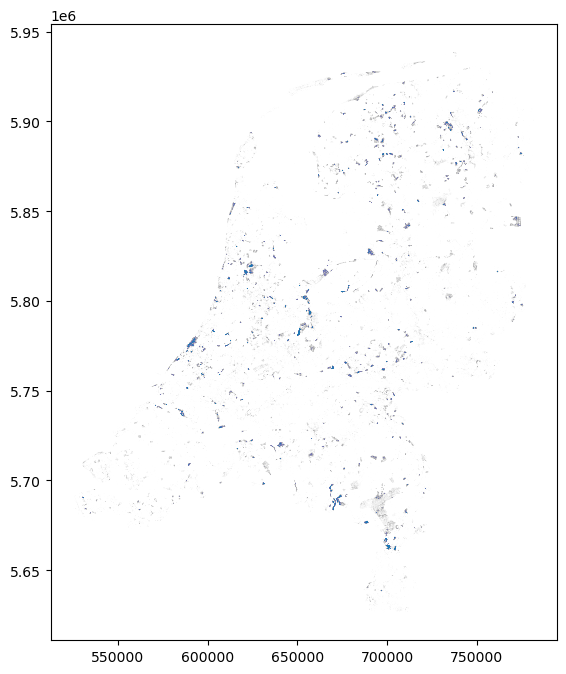

In [24]:
aoi_obs_gdf.plot(figsize=(12, 8))

### Create a GeoDataFrame with a grid
Construct a grid that covers the extent of the area of interest. This will later be used to aggregate the data into.


In [25]:
# total area for the grid
xmin, ymin, xmax, ymax= aoi_obs_gdf.total_bounds

# how many cells across and down
n_cells = 100
cell_size = (xmax - xmin) / n_cells

# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax + cell_size, cell_size):
    for y0 in np.arange(ymin, ymax + cell_size, cell_size):
        # bounds
        x1 = x0 - cell_size
        y1 = y0 + cell_size
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))

grid_gdf = gp.GeoDataFrame(grid_cells, columns=['geometry'], crs=aoi_epsg)

In [26]:
grid_gdf.head(3)

,geometry
0,"POLYGON ((522808.623 5626504.637, 522808.623 5..."
1,"POLYGON ((522808.623 5629069.142, 522808.623 5..."
2,"POLYGON ((522808.623 5631633.648, 522808.623 5..."


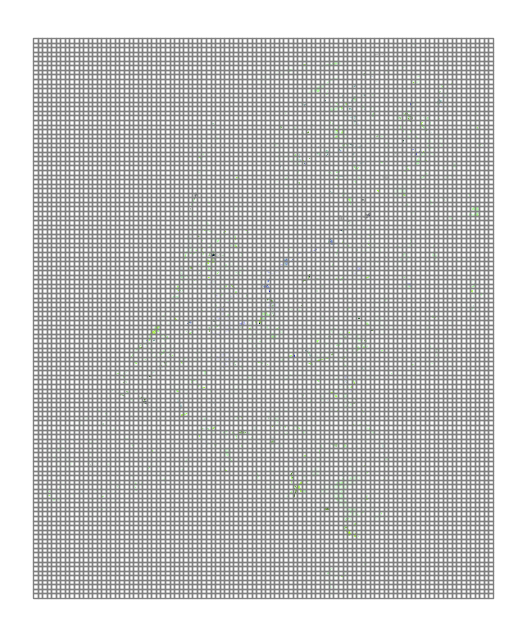

In [27]:
# plot the grid over the observations data
ax = aoi_obs_gdf.plot(markersize=0.5, figsize=(12, 8), column='straal', cmap='jet')
# plt.autoscale(False)
grid_gdf.plot(ax=ax, facecolor="none", edgecolor='grey')
ax.axis("off");

### Merge the observations with the grid
Merge the observations with the grid using a spatial join. Then use a simple count to aggregate the data.

In [28]:
merged_aoi_gdf = gp.sjoin(aoi_obs_gdf, grid_gdf, how='left', predicate='within')

In [29]:
# make a count column
merged_aoi_gdf['n_obs'] = 1

# dissolve by count
dissolve = merged_aoi_gdf.dissolve(by='index_right', aggfunc='count')

# put the values into the grid
grid_gdf.loc[dissolve.index, 'n_obs'] = dissolve['n_obs'].values

/Users/robknapen/opt/mambaforge/envs/fairicube-pt2/lib/python3.11/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


<Axes: >

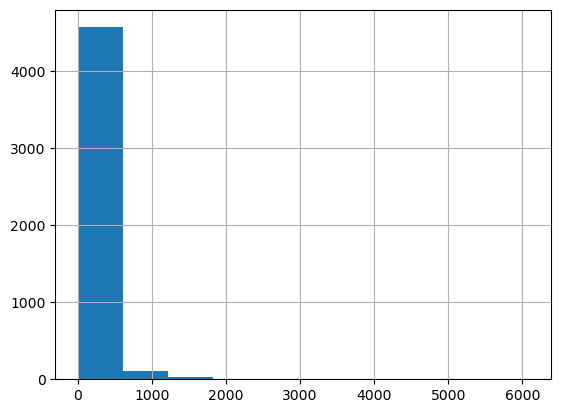

In [30]:
grid_gdf['n_obs'].hist()

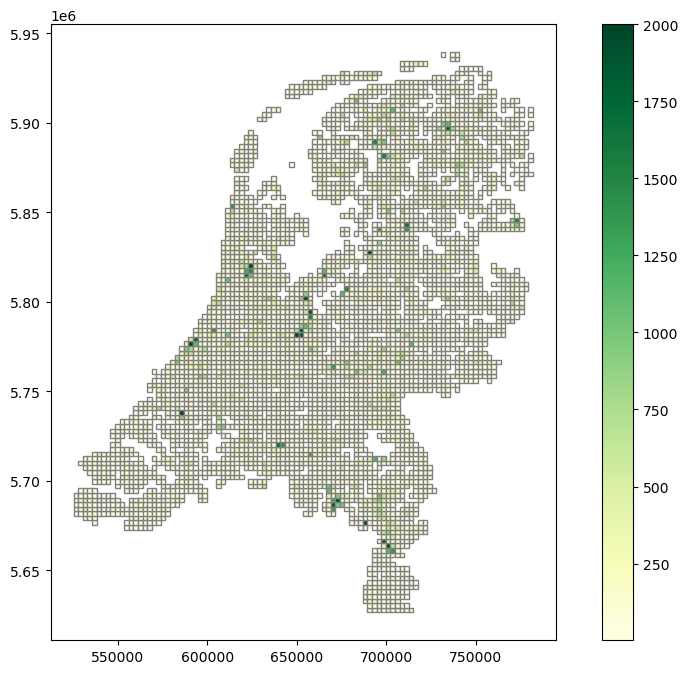

In [31]:
# plot the grid and the number of observations in each grid cell
grid_gdf.plot(
    column='n_obs',
    figsize=(12, 8),
    cmap='YlGn',
    vmax=2000, # range max, take from the histogram
    edgecolor='grey',
    legend=True
);

In [ ]:
# grid_gdf.explore(column='n_obs', cmap='viridis', vmax=2000)

### Rasterize the grid cell polygons and write to GeoTIFF
One quick way to do this is with the geocube package:
    https://corteva.github.io/geocube/

Note that this package can also perform some operations when rasterizing data, so in some cases it might be sufficient!

In [32]:
out_grid = make_geocube(
    vector_data=grid_gdf,
    measurements=['n_obs'],
    resolution=(10.0, 10.0)
)

# write the file (with CRS)
out_grid['n_obs'].rio.to_raster("obs_count_broedvogels_2016_nl.tif")